In [1]:
from configs.config import get_path
import src.utils.presenter as show
import src.utils.checker as check

import src.utils.gen_jobs as rp_proced

import src.models.cp.lateness as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

import time
import pandas as pd
pd.set_option('display.max_rows', 26)

In [2]:
max_time = 60*60*2 # 2h
max_time = 60*20 # 20 min

## Laden der Produktionsaufträge

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [4]:
file = file_template.format(text= "all_jobs")

df_jobs_all = pd.read_csv(data_path / file)
df_jobs_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2297,1440,395,462
1,Job_001,81,3047,1440,510,1097
2,Job_002,101,3404,1440,568,1396
3,Job_003,142,3950,1440,655,1855
4,Job_004,177,2462,1440,393,629
...,...,...,...,...,...,...
407,Job_407,25679,28813,25920,539,2354
408,Job_408,25759,29231,25920,597,2714
409,Job_409,25773,28913,25920,540,2453
410,Job_410,25881,28178,25920,395,1863


In [5]:
df_jobs_all.loc[df_jobs_all['Arrival'].idxmin(), 'Job']

'Job_000'

In [6]:
file = file_template.format(text= "all_ops")
df_ops_all = pd.read_csv(data_path / file)
df_ops_all

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
4115,Job_411,5,M6,88
4116,Job_411,6,M8,19
4117,Job_411,7,M9,48
4118,Job_411,8,M7,36


## Laden der Initialisierungsdaten vom Tag 1

In [7]:
day_numb = 1

In [8]:
# Waiting Plan
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
df_plan_waiting = pd.read_csv(data_path / file)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,9,M8,81,3047,3017,30,3047,0,0,0
1,Job_002,9,M4,101,3404,3371,33,3404,0,0,0
2,Job_003,3,M4,142,3950,2974,99,3073,-877,0,877
3,Job_003,4,M6,142,3950,3081,9,3090,-860,0,860
4,Job_003,5,M8,142,3950,3110,52,3162,-788,0,788
...,...,...,...,...,...,...,...,...,...,...,...
105,Job_031,5,M1,1424,4390,3081,28,3109,-1281,0,1281
106,Job_031,6,M6,1424,4390,3291,46,3337,-1053,0,1053
107,Job_031,7,M5,1424,4390,3337,46,3383,-1007,0,1007
108,Job_031,8,M7,1424,4390,3723,72,3795,-595,0,595


In [9]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,19.98,1459.98,1459.98
1,Job_000,1,0,M1,1486.00,93.25,1579.25,1579.25
2,Job_000,2,0,M2,1636.00,9.98,1645.98,1645.98
3,Job_000,3,0,M3,1650.80,27.84,1678.64,1678.64
4,Job_000,4,0,M4,1681.00,45.47,1726.47,1726.47
...,...,...,...,...,...,...,...,...
190,Job_030,5,1423,M5,2699.04,15.78,1291.82,2714.82
191,Job_031,0,1424,M0,2323.13,29.33,928.46,2352.46
192,Job_031,1,1424,M2,2360.00,76.09,1012.09,2436.09
193,Job_031,2,1424,M4,2593.44,43.99,1213.43,2637.43


In [10]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_plan_undone = pd.read_csv(data_path / file)
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_021,4,970,M8,2631,48
1,Job_011,7,498,M3,2683,52
2,Job_019,0,808,M1,2766,81
3,Job_022,1,1050,M0,2768,13
4,Job_022,2,1050,M2,2781,61
5,Job_021,5,970,M9,2783,72
6,Job_017,2,625,M3,2804,39
7,Job_011,8,498,M4,2808,90
8,Job_028,6,1391,M6,2823,62
9,Job_017,3,625,M2,2843,74


In [11]:
def print_earliest_job(df_jobs_waiting, info="Info"):
    """
    Gibt den frühesten wartenden Job mit Ankunftszeit und Deadline in einer Zeile formatiert aus.

    Format:
    <Info> frühste: <Jobname>    Arrival: <arrival>    Deadline: <deadline>

    Parameter:
    df_jobs_waiting (pd.DataFrame): DataFrame mit Spalten 'Job', 'Arrival' und 'Deadline'.
    info (str): Informationstext für die Ausgabe.
    """
    if df_jobs_waiting.empty:
        print(f"{info} earliest: Keine wartenden Jobs vorhanden.")
        return

    row = df_jobs_waiting.loc[df_jobs_waiting['Arrival'].idxmin()]
    jobname = row['Job']
    arrival = row['Arrival']
    deadline = row['Deadline']
    print(f"\t{info} earliest {jobname}:\tArrival: {arrival}\tDeadline: {deadline}")


## Rolling Planning ab Tag 2

In [12]:
file_template = "03_simple_{text}.csv"

In [13]:
first_start = 2
last_planning_start = 10

day_length = 1440

Day 02: [2880, 4320)
	Current earliest Job_032:	Arrival: 1445	Deadline: 3864
	Undone earliest Job_011:	Arrival: 498	Deadline: 3638
	Wating earliest Job_001:	Arrival: 81	Deadline: 3047

Solver-Status         : OPTIMAL
Objective Value       : 2.00
Best Objective Bound  : 2.00
Laufzeit              : 0.16 Sekunden


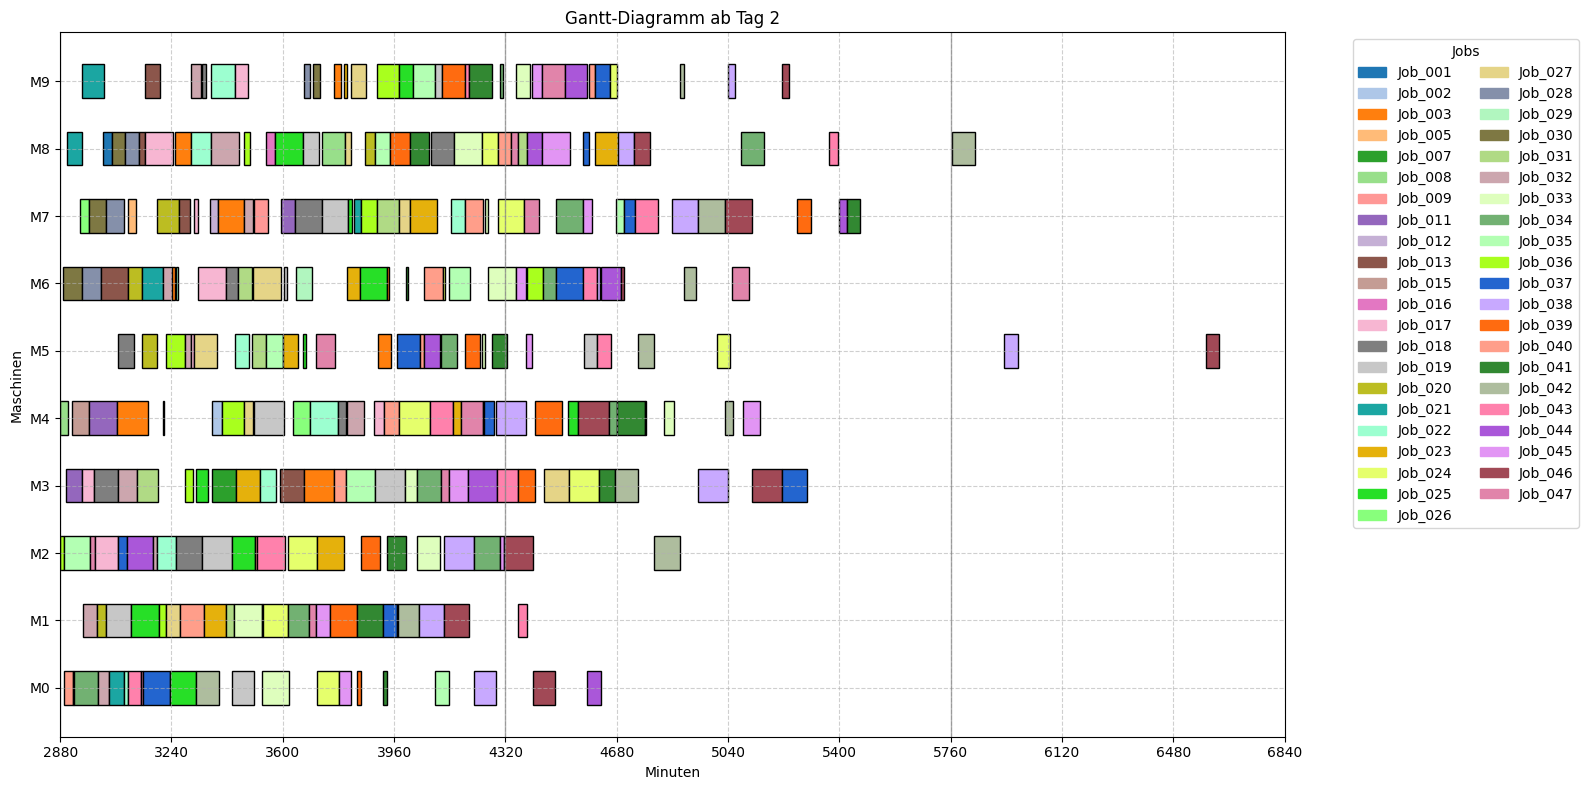

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              42
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 71
[48:00:00] Job_008 started on M4
[48:00:00] Job_036 started on M2
[48:08:00] Job_030 started on M6
[48:11:00] Job_040 started on M0
[48:12:07] Job_008 finished on M4 (after 12 minutes 07 seconds)
[48:13:55] Job_036 finished on M2 (after 13 minutes 55 seconds)
[48:14:00] Job_035 started on M2
[48:20:00] Job_011 started on M3
[48:23:00] Job_021 started on M8
[48:39:00] Job_015 started on M4
[48:39:40] Job_040 finished on M0 (after 28 minutes 41 seconds)
[48:40:00] Job_036 started on M0
[48:46:21] Job_036 finished on M0 (afte

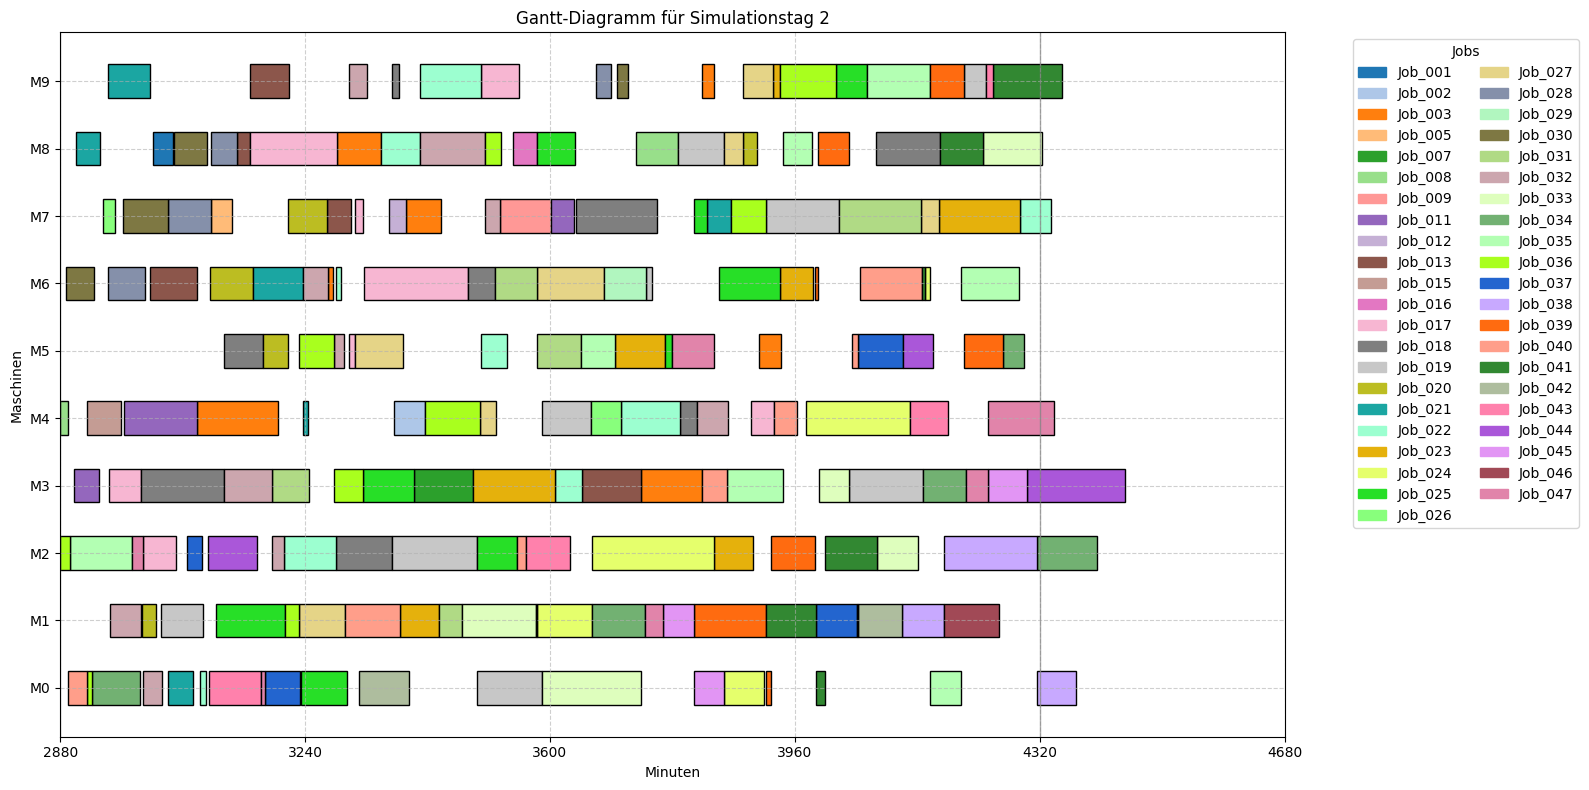

Number of undone operations: 16
_______________________________________________________________________________
Day 03: [4320, 5760)
	Current earliest Job_048:	Arrival: 2930	Deadline: 6064
	Undone earliest Job_023:	Arrival: 1211	Deadline: 4683
	Wating earliest Job_019:	Arrival: 808	Deadline: 4616

Solver-Status         : OPTIMAL
Objective Value       : 59.00
Best Objective Bound  : 59.00
Laufzeit              : 0.33 Sekunden


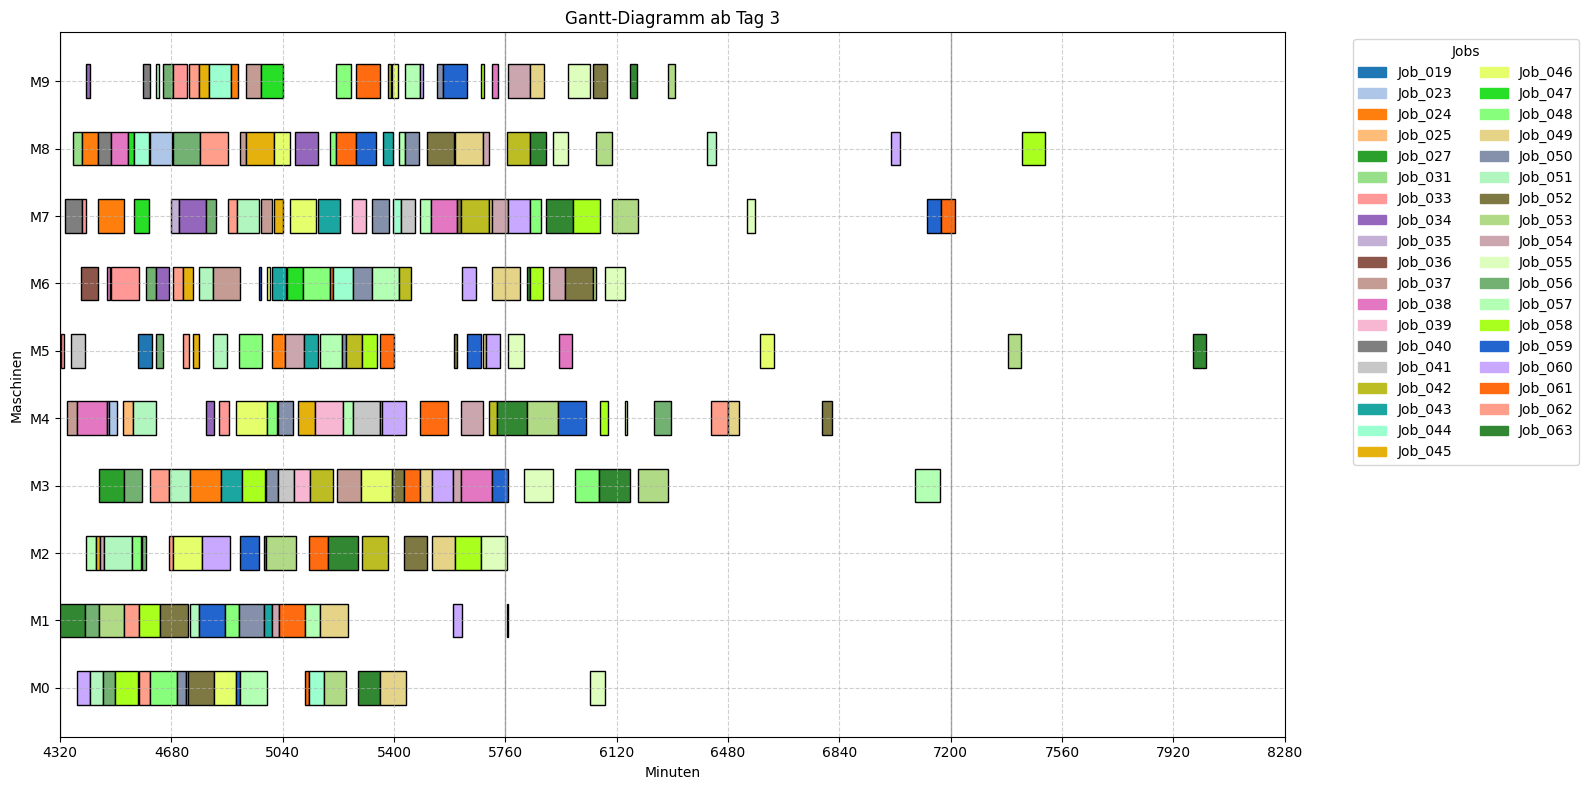

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              33
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 47
[72:00:00] Job_063 started on M1
[72:04:00] Job_033 started on M5
[72:11:22] Job_033 finished on M5 (after 07 minutes 23 seconds)
[72:16:00] Job_040 started on M7
[72:22:00] Job_037 started on M4
[72:34:00] Job_041 started on M5
[72:40:00] Job_031 started on M8
[72:46:21] Job_037 finished on M4 (after 24 minutes 21 seconds)
[72:54:00] Job_038 started on M4
[72:54:00] Job_060 started on M0
[73:04:58] Job_031 finished on M8 (after 24 minutes 59 seconds)
[73:09:00] Job_036 started on M6
[73:10:00] Job_024 started on M8
[73:12

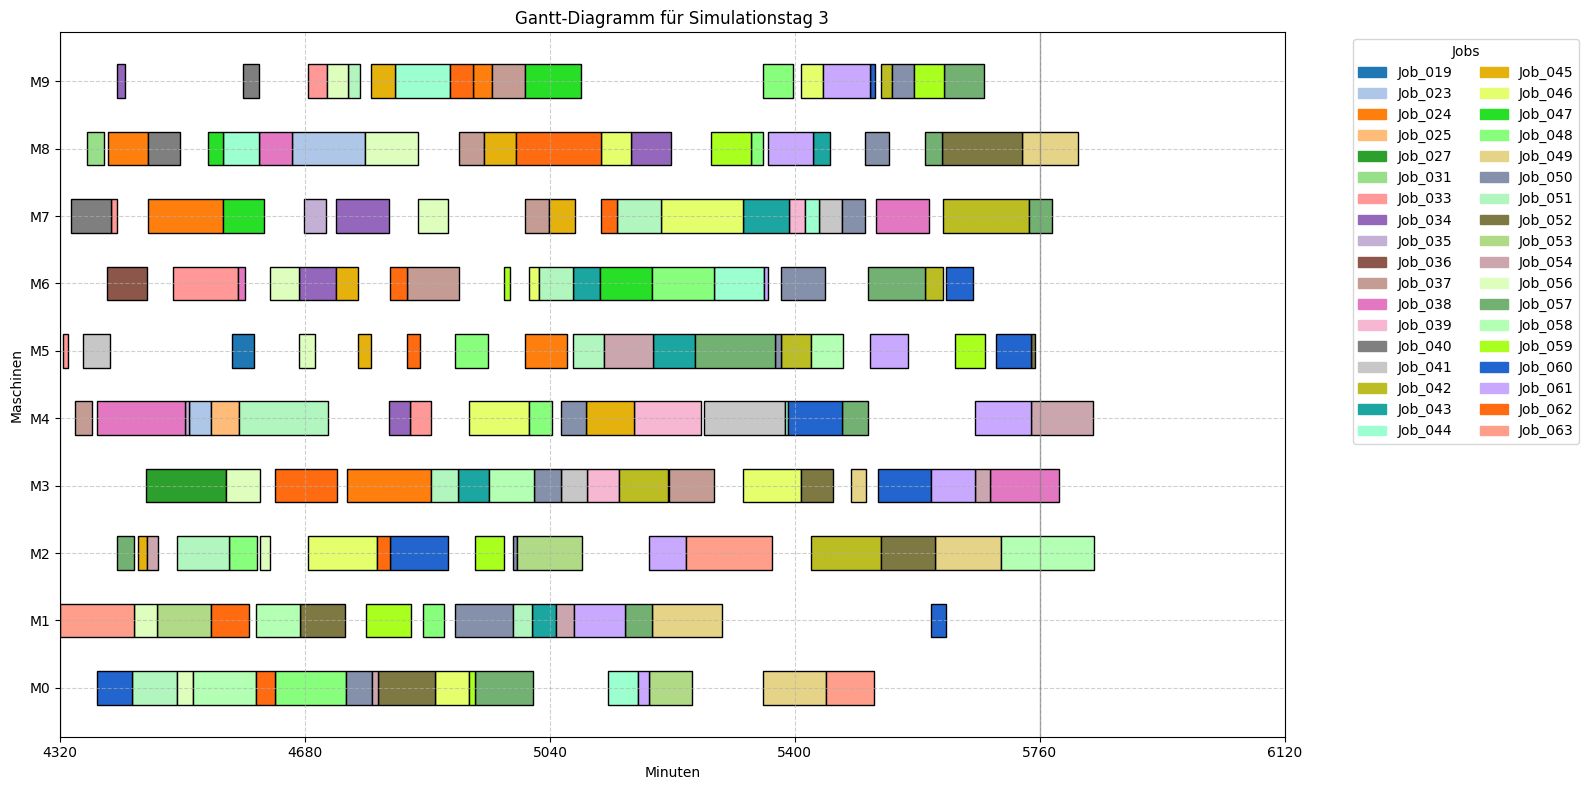

Number of undone operations: 12
_______________________________________________________________________________
Day 04: [5760, 7200)
	Current earliest Job_064:	Arrival: 4352	Deadline: 7655
	Undone earliest Job_038:	Arrival: 2167	Deadline: 5976
	Wating earliest Job_038:	Arrival: 2167	Deadline: 5976

Solver-Status         : OPTIMAL
Objective Value       : 956.00
Best Objective Bound  : 956.00
Laufzeit              : 5.99 Sekunden


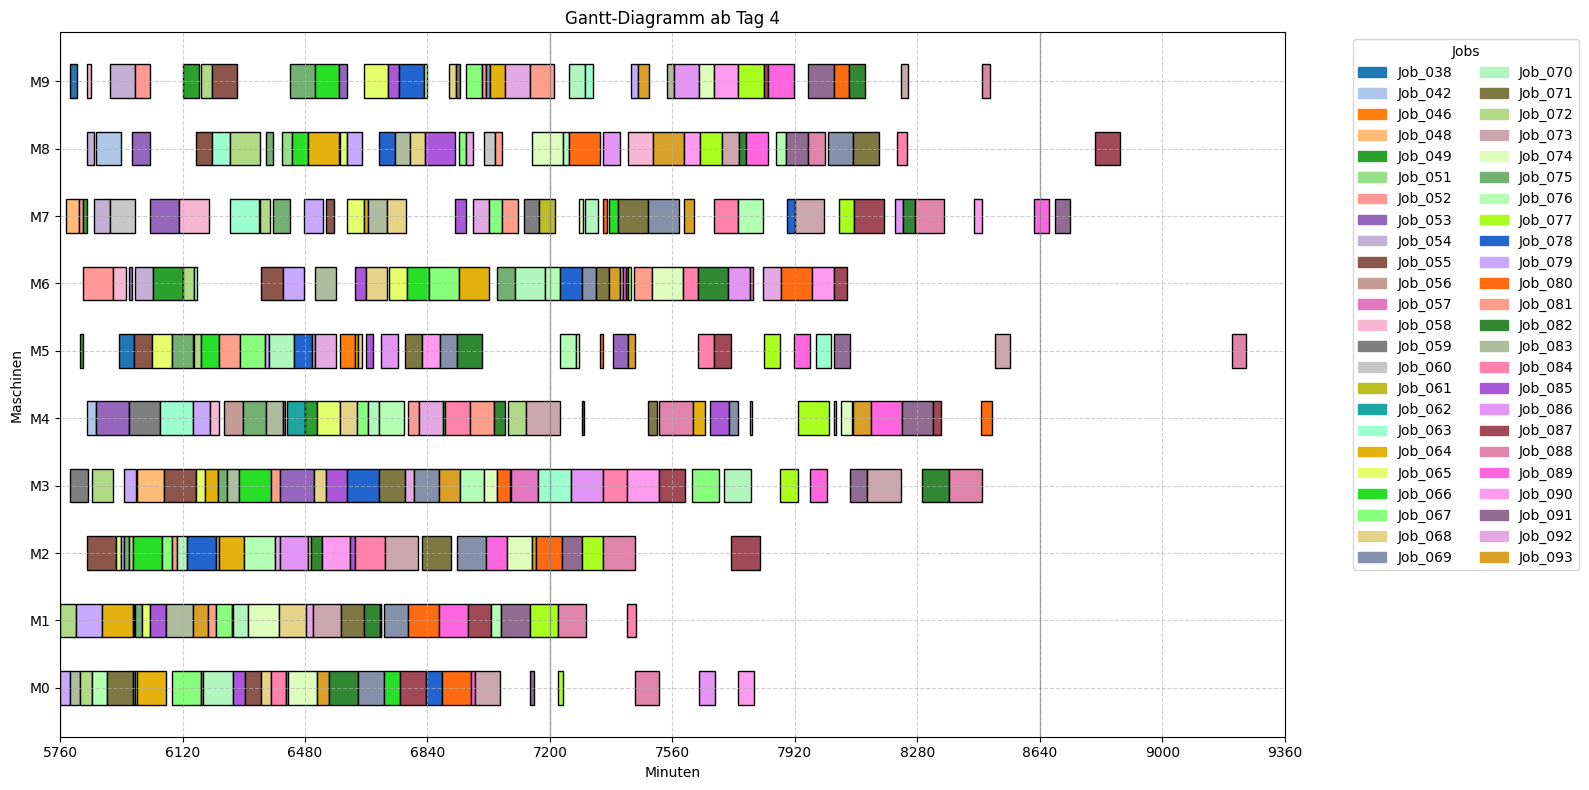

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              43
0 - 60          0
60 - 120        2
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 120
[96:00:00] Job_072 started on M1
[96:00:00] Job_079 started on M0
[96:18:00] Job_048 started on M7
[96:29:00] Job_038 started on M9
[96:29:00] Job_059 started on M3
[96:30:50] Job_079 finished on M0 (after 30 minutes 50 seconds)
[96:30:50] Job_083 started on M0
[96:43:53] Job_038 finished on M9 (after 14 minutes 54 seconds)
[96:51:28] Job_083 finished on M0 (after 20 minutes 38 seconds)
[96:52:58] Job_048 finished on M7 (after 34 minutes 59 seconds)
[96:54:00] Job_052 started on M7
[96:57:00] Job_049 started on M5
[97:03:

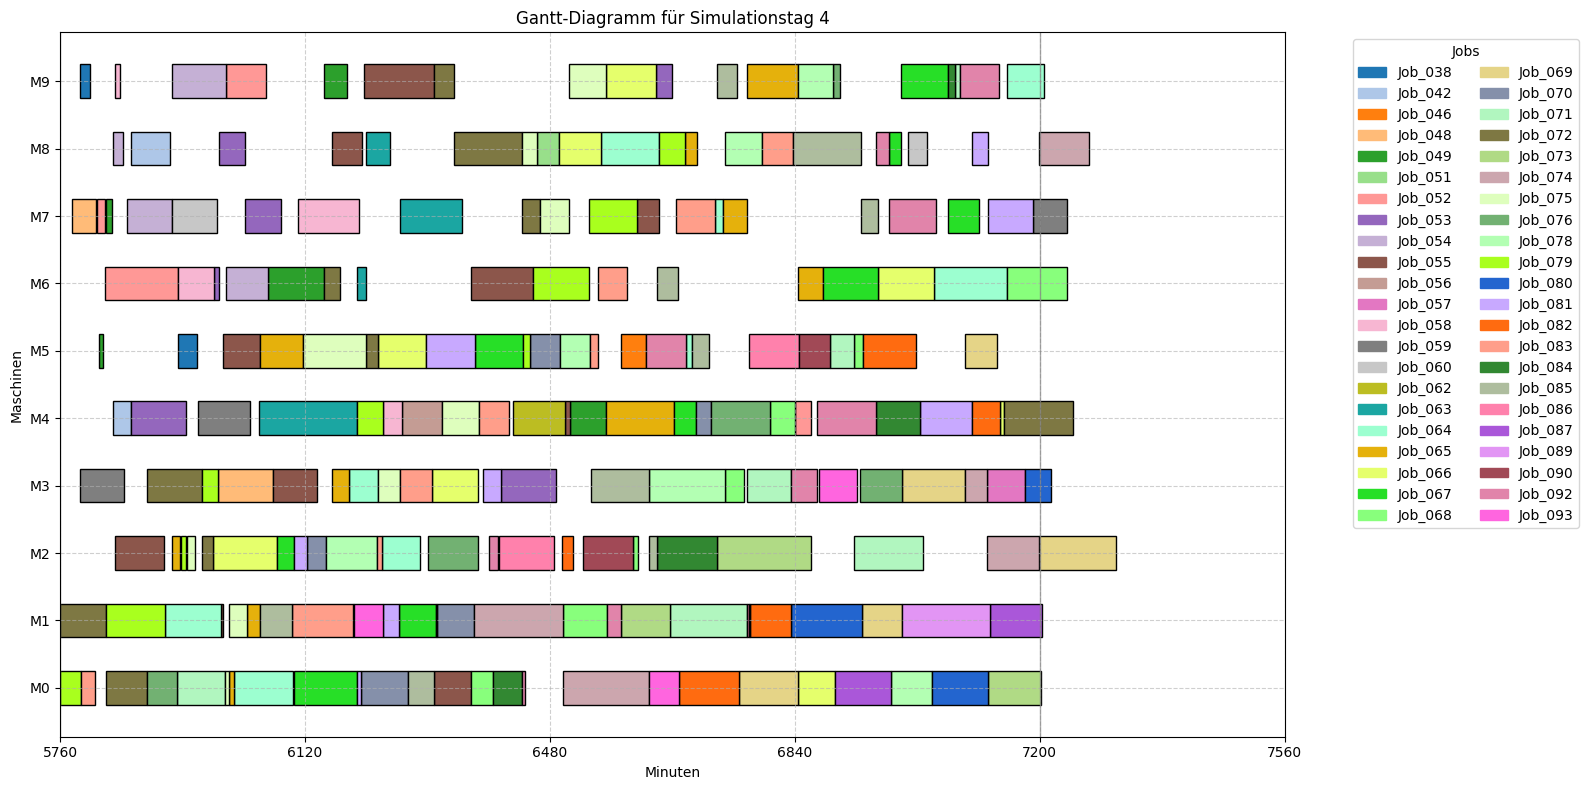

Number of undone operations: 19
_______________________________________________________________________________
Day 05: [7200, 8640)
	Current earliest Job_094:	Arrival: 5804	Deadline: 9108
	Undone earliest Job_061:	Arrival: 4074	Deadline: 7214
	Wating earliest Job_053:	Arrival: 3620	Deadline: 7429

Solver-Status         : OPTIMAL
Objective Value       : 3786.00
Best Objective Bound  : 3780.00
Laufzeit              : 6.46 Sekunden


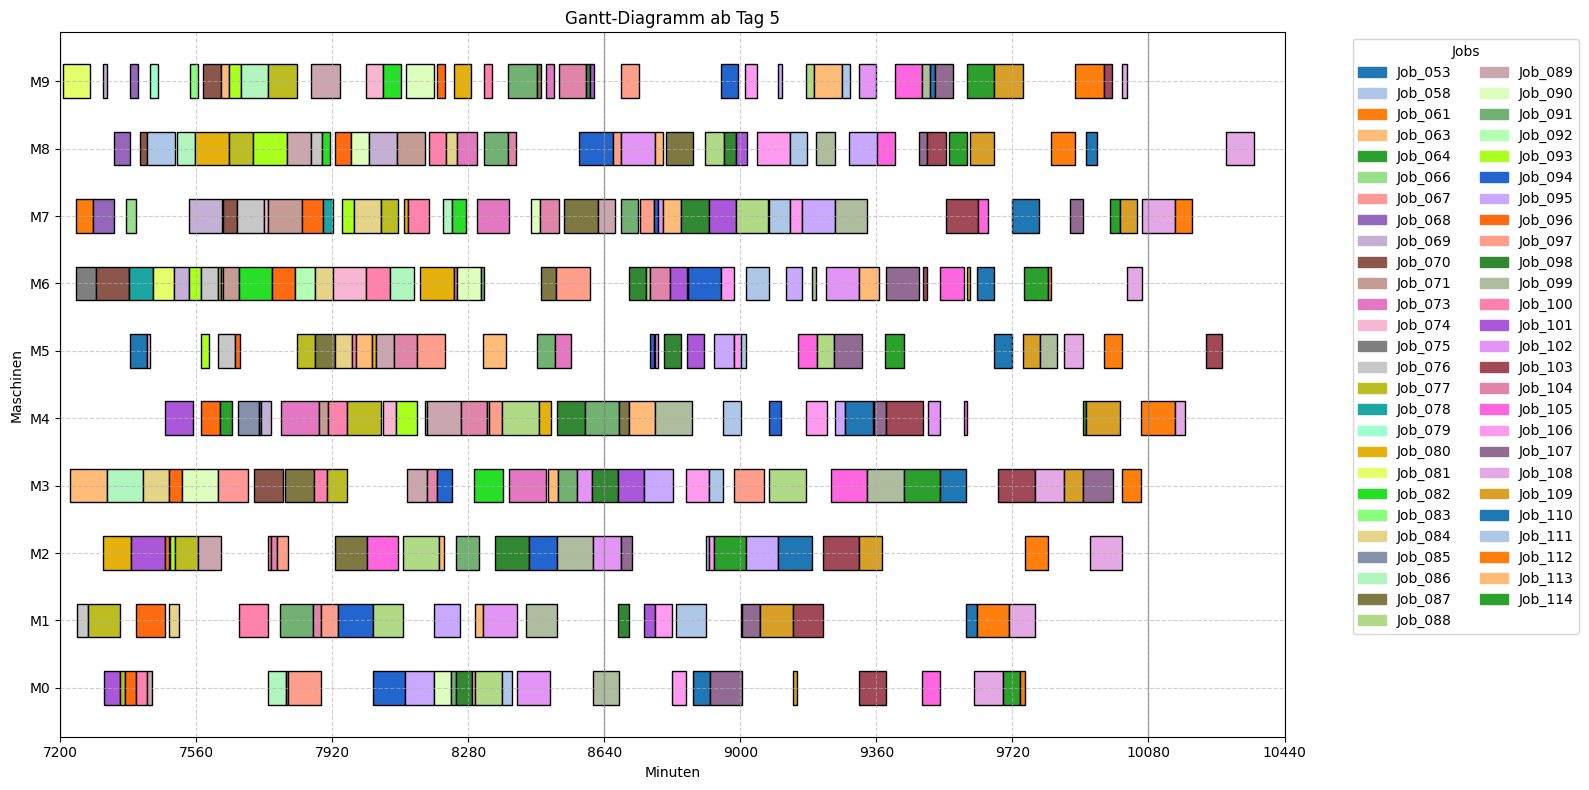

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              45
0 - 60          0
60 - 120        1
120 - 180       0
180 - 240       1
>240            1
Name: count, dtype: int64
Number of waiting operations: 154
[120:07:00] Job_081 started on M9
[120:25:00] Job_063 started on M3
[120:41:00] Job_061 started on M7
[120:41:00] Job_075 started on M6
[120:45:00] Job_076 started on M1
[121:06:09] Job_076 finished on M1 (after 21 minutes 10 seconds)
[121:13:00] Job_077 started on M1
[121:22:25] Job_081 finished on M9 (after 75 minutes 25 seconds)
[121:30:32] Job_061 finished on M7 (after 49 minutes 32 seconds)
[121:30:32] Job_068 started on M7
[121:53:00] Job_069 started on M9
[121:53:00] Job_080 started on M2
[121:55:00] Job_101 starte

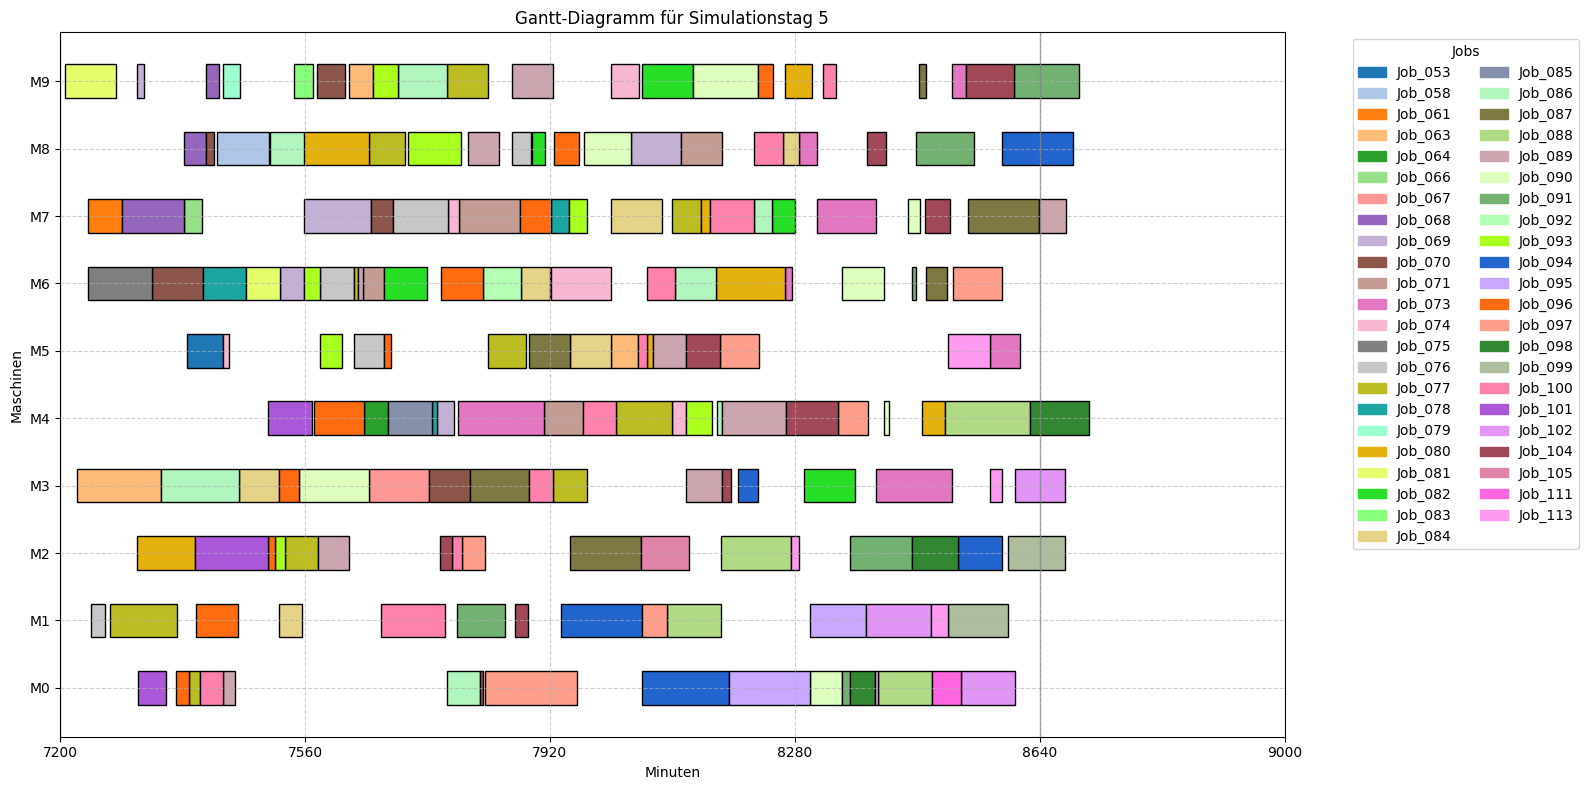

Number of undone operations: 8
_______________________________________________________________________________
Day 06: [8640, 10080)
	Current earliest Job_115:	Arrival: 7224	Deadline: 10696
	Undone earliest Job_091:	Arrival: 5589	Deadline: 8729
	Wating earliest Job_087:	Arrival: 5404	Deadline: 8876

Solver-Status         : FEASIBLE
Objective Value       : 4014.00
Best Objective Bound  : 3779.00
Laufzeit              : 1200.55 Sekunden


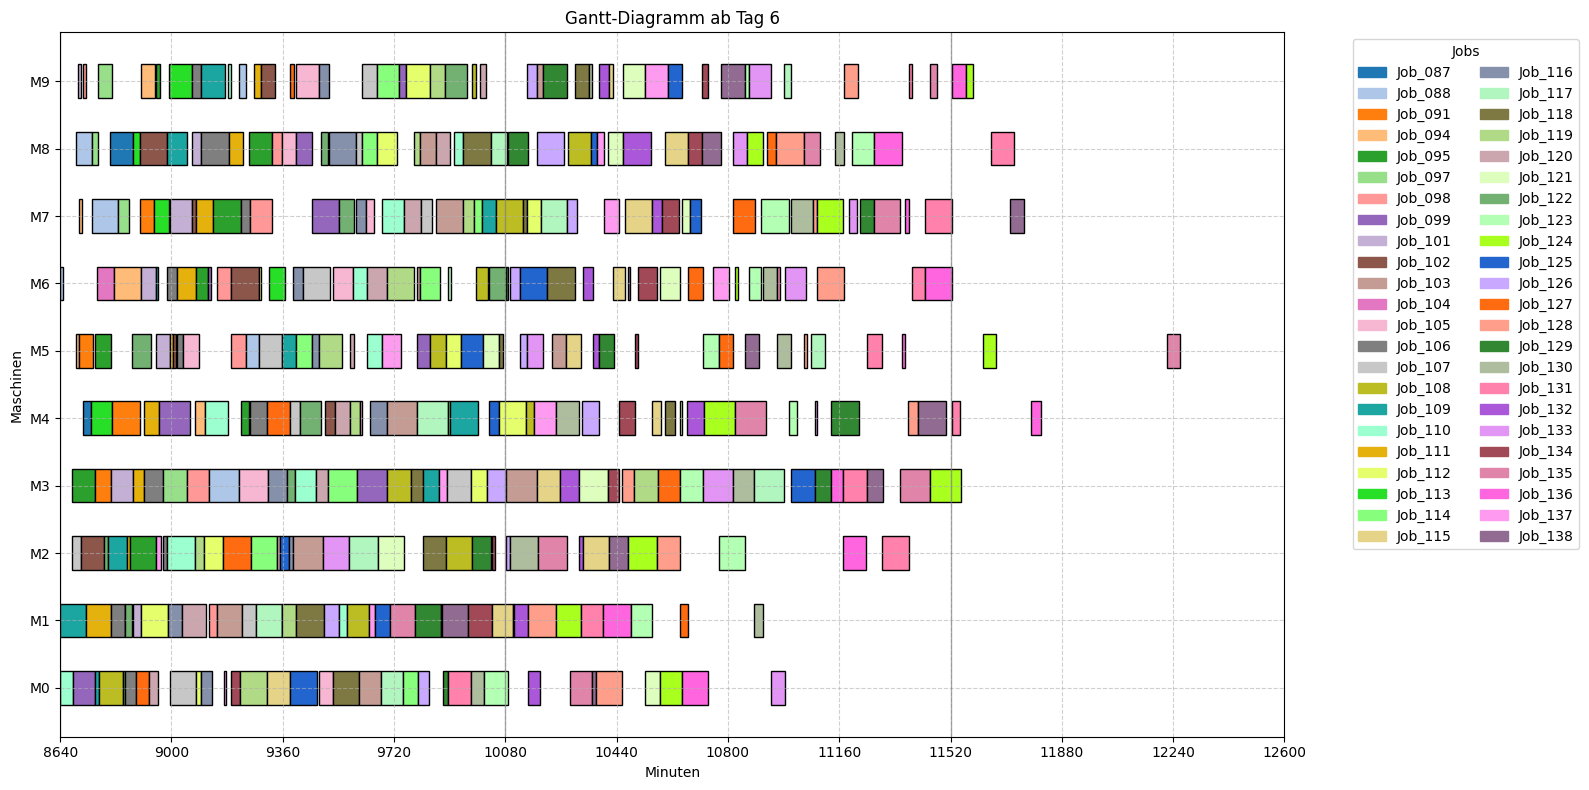

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              35
0 - 60          2
60 - 120        2
120 - 180       0
180 - 240       1
>240            1
Name: count, dtype: int64
Number of waiting operations: 161
[144:00:00] Job_088 started on M6
[144:00:00] Job_109 started on M1
[144:00:00] Job_110 started on M0
[144:06:22] Job_088 finished on M6 (after 06 minutes 23 seconds)
[144:37:00] Job_107 started on M2
[144:38:00] Job_095 started on M3
[144:41:47] Job_110 finished on M0 (after 41 minutes 48 seconds)
[144:43:00] Job_099 started on M0
[144:50:00] Job_094 started on M5
[144:50:00] Job_088 started on M8
[144:57:40] Job_094 finished on M5 (after 07 minutes 40 seconds)
[144:58:00] Job_101 started on M9
[145:00:00] Job_091 starte

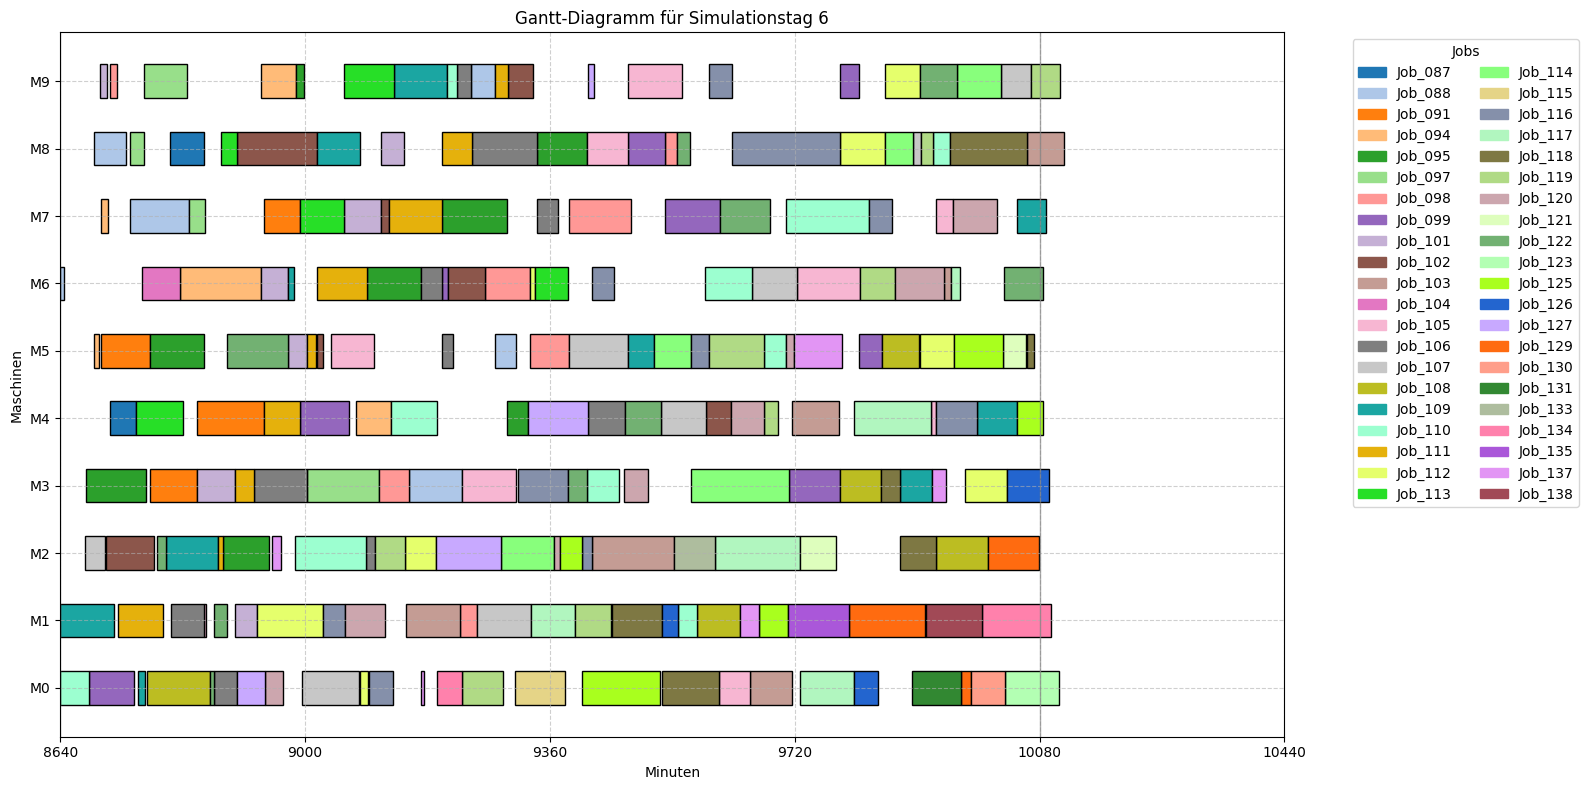

Number of undone operations: 17
_______________________________________________________________________________
Day 07: [10080, 11520)
	Current earliest Job_139:	Arrival: 8644	Deadline: 11778
	Undone earliest Job_103:	Arrival: 6466	Deadline: 10275
	Wating earliest Job_103:	Arrival: 6466	Deadline: 10275

Solver-Status         : FEASIBLE
Objective Value       : 16478.00
Best Objective Bound  : 9100.00
Laufzeit              : 1208.44 Sekunden


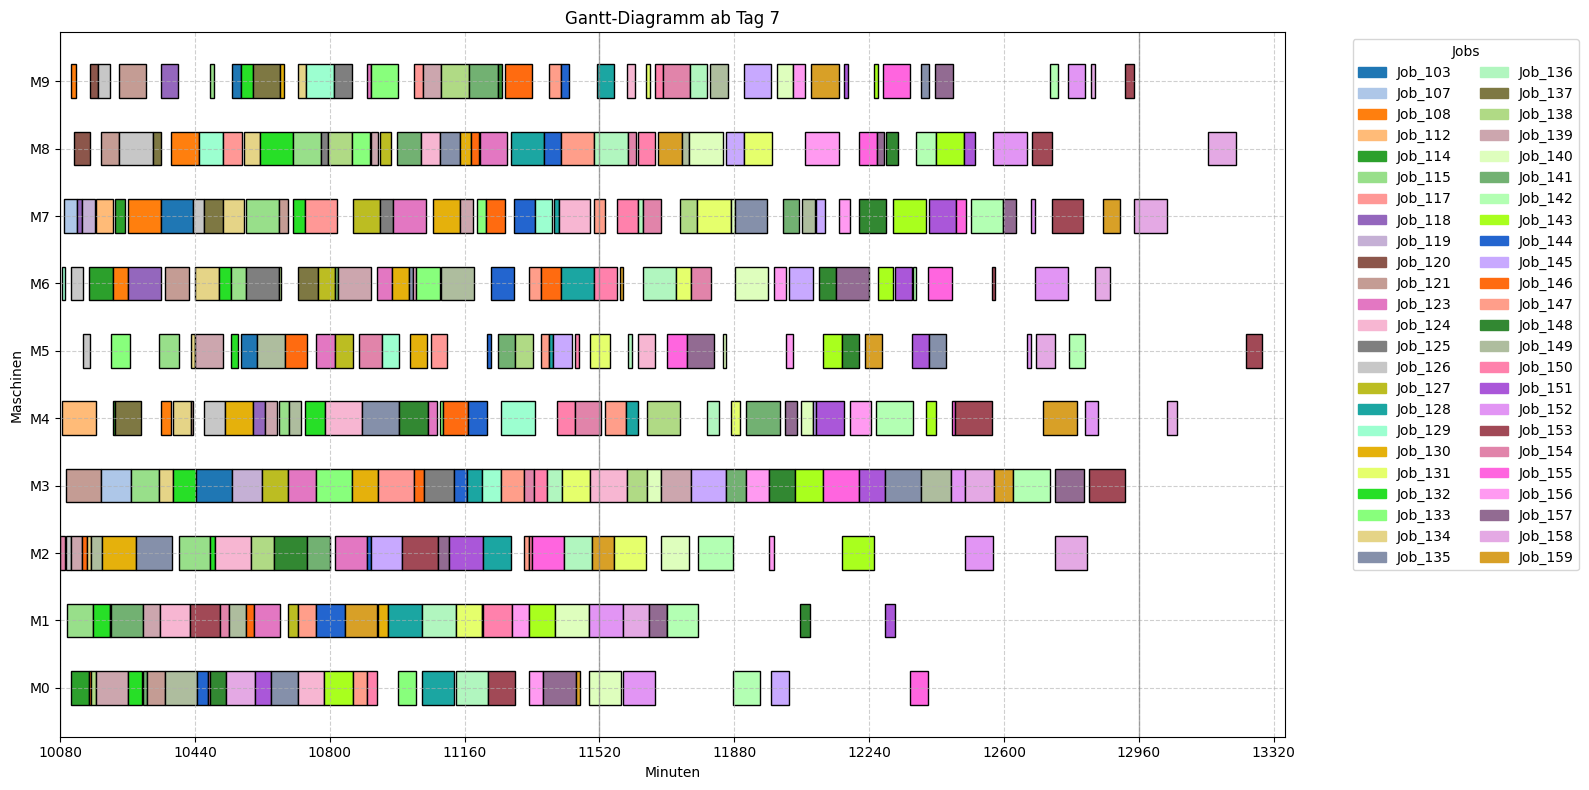

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              13
0 - 60         11
60 - 120        7
120 - 180       6
180 - 240       2
>240            4
Name: count, dtype: int64
Number of waiting operations: 141
[168:00:00] Job_154 started on M2
[168:05:00] Job_112 started on M4
[168:05:00] Job_129 started on M6
[168:10:00] Job_107 started on M7
[168:12:46] Job_129 finished on M6 (after 07 minutes 47 seconds)
[168:15:00] Job_121 started on M3
[168:15:15] Job_154 finished on M2 (after 15 minutes 15 seconds)
[168:15:15] Job_126 started on M2
[168:18:00] Job_115 started on M1
[168:29:00] Job_114 started on M0
[168:30:00] Job_108 started on M9
[168:32:35] Job_126 finished on M2 (after 17 minutes 20 seconds)
[168:32:35] Job_139 starte

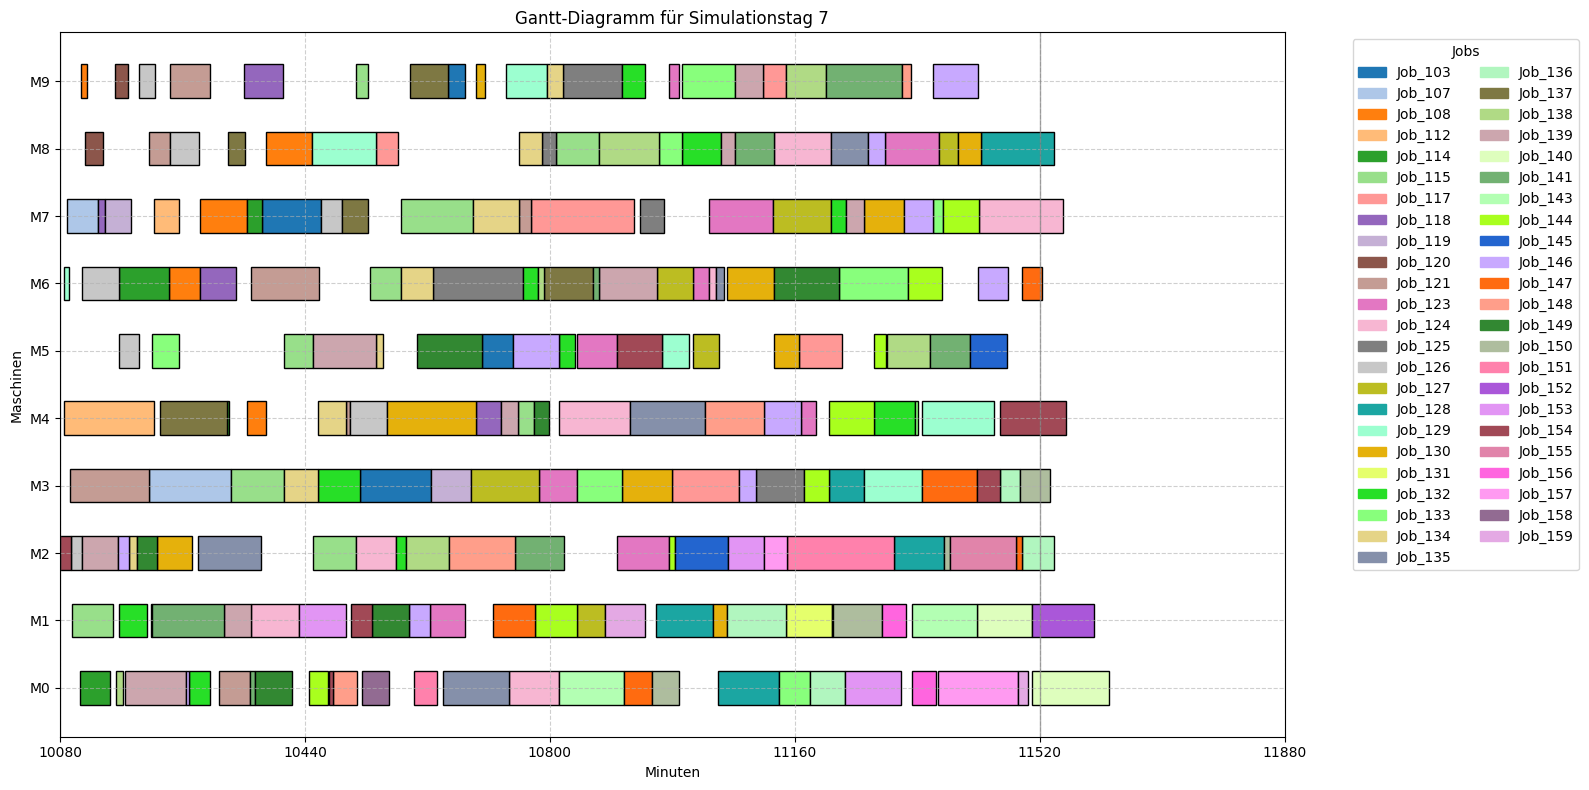

Number of undone operations: 19
_______________________________________________________________________________
Day 08: [11520, 12960)
	Current earliest Job_160:	Arrival: 10092	Deadline: 13227
	Undone earliest Job_124:	Arrival: 7858	Deadline: 11667
	Wating earliest Job_124:	Arrival: 7858	Deadline: 11667

Solver-Status         : FEASIBLE
Objective Value       : 32877.00
Best Objective Bound  : 25218.00
Laufzeit              : 1212.19 Sekunden


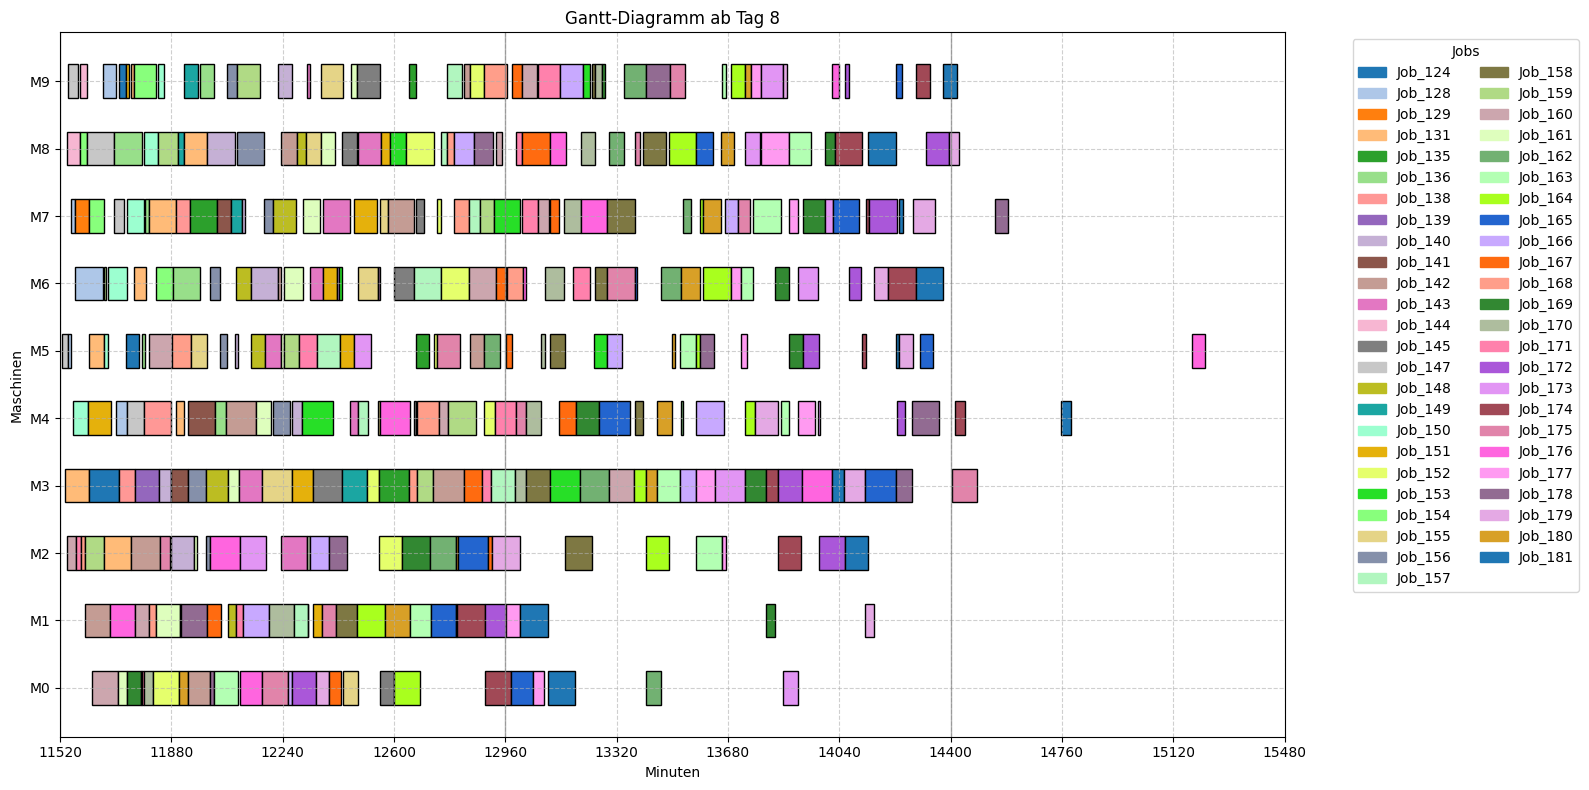

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              11
0 - 60          4
60 - 120        7
120 - 180      10
180 - 240       5
>240            9
Name: count, dtype: int64
Number of waiting operations: 150
[192:05:00] Job_147 started on M5
[192:16:00] Job_131 started on M3
[192:21:00] Job_144 started on M8
[192:21:00] Job_160 started on M2
[192:31:01] Job_147 finished on M5 (after 26 minutes 02 seconds)
[192:31:01] Job_128 started on M5
[192:31:01] Job_147 started on M9
[192:40:00] Job_150 started on M4
[192:41:36] Job_128 finished on M5 (after 10 minutes 35 seconds)
[192:41:36] Job_128 started on M7
[192:52:01] Job_128 finished on M7 (after 10 minutes 25 seconds)
[192:52:01] Job_129 started on M7
[192:52:01] Job_128 starte

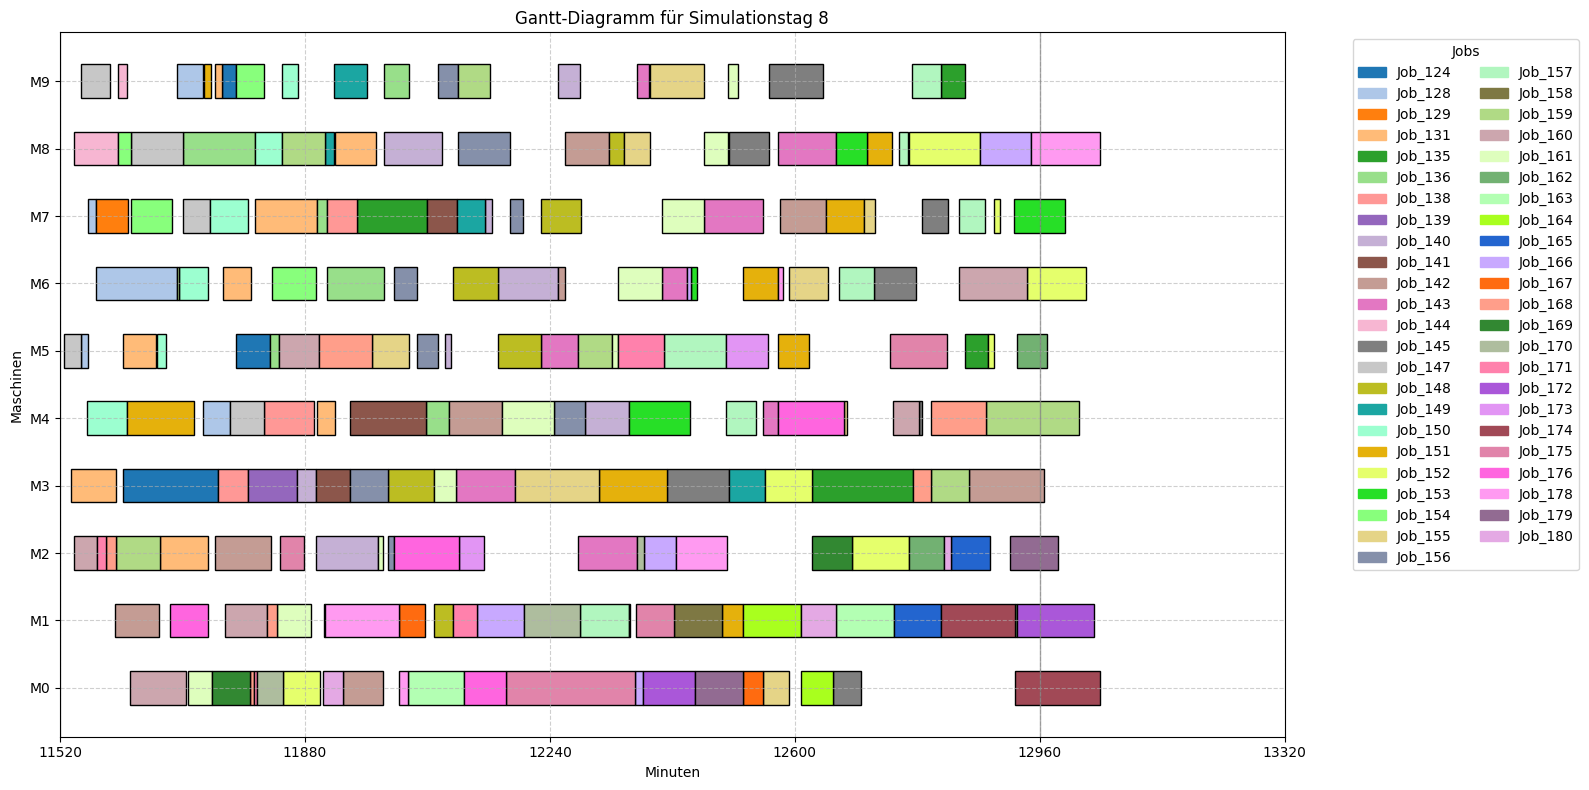

Number of undone operations: 15
_______________________________________________________________________________
Day 09: [12960, 14400)
	Current earliest Job_182:	Arrival: 11613	Deadline: 14498
	Undone earliest Job_142:	Arrival: 9008	Deadline: 12817
	Wating earliest Job_153:	Arrival: 9480	Deadline: 13289

Solver-Status         : FEASIBLE
Objective Value       : 53092.00
Best Objective Bound  : 37455.00
Laufzeit              : 1210.36 Sekunden


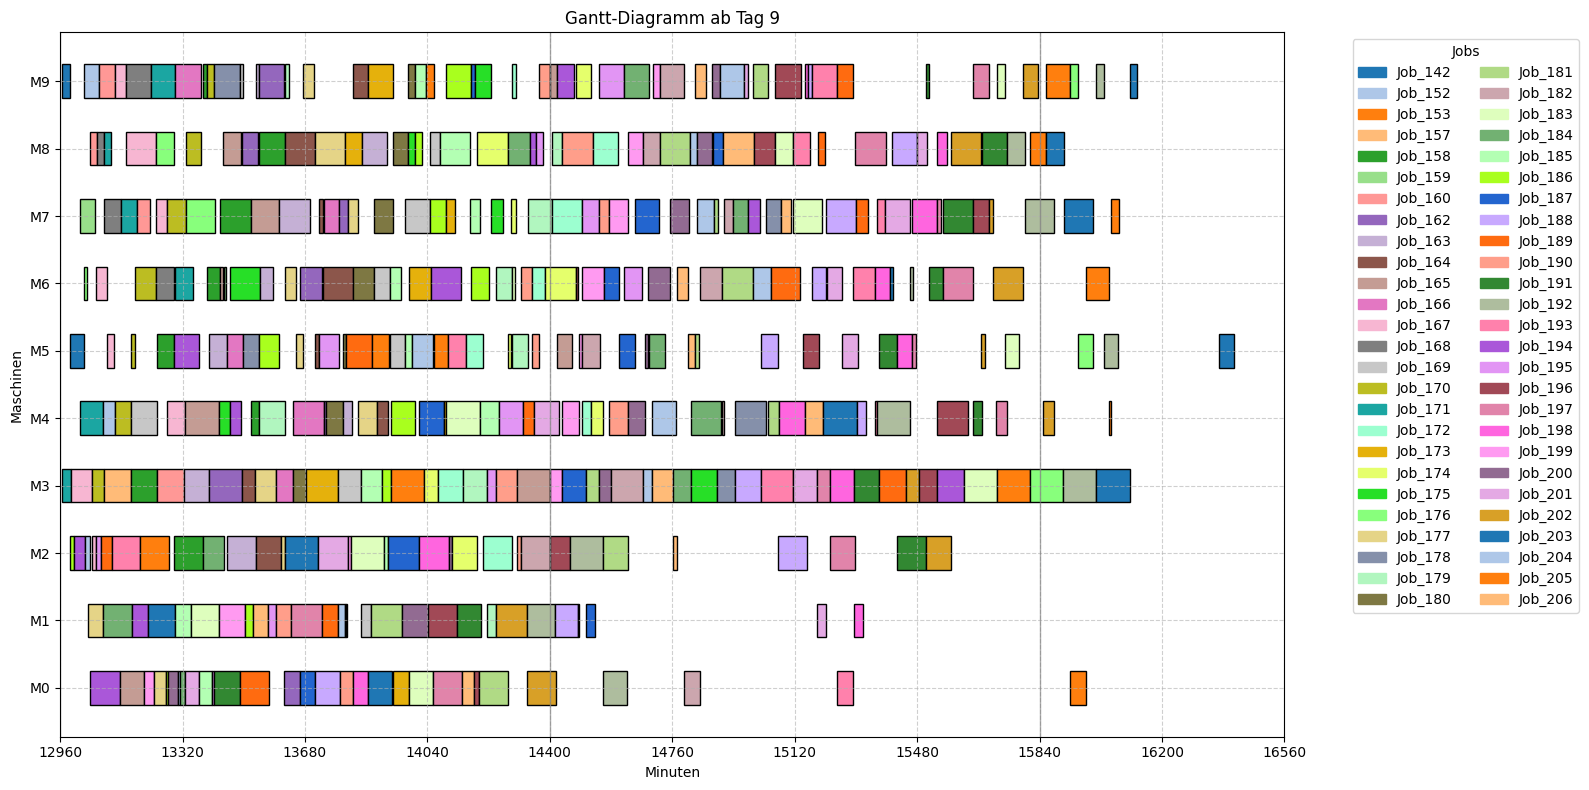

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0               5
0 - 60          5
60 - 120        8
120 - 180      10
180 - 240       5
>240           17
Name: count, dtype: int64
Number of waiting operations: 175
[216:06:00] Job_142 started on M9
[216:06:00] Job_171 started on M3
[216:20:04] Job_171 finished on M3 (after 14 minutes 05 seconds)
[216:28:00] Job_186 started on M2
[216:32:00] Job_167 started on M3
[216:32:22] Job_142 finished on M9 (after 26 minutes 23 seconds)
[216:32:22] Job_142 started on M5
[216:47:01] Job_186 finished on M2 (after 19 minutes 02 seconds)
[216:47:01] Job_194 started on M2
[216:58:00] Job_159 started on M7
[216:58:00] Job_171 started on M4
[217:09:00] Job_152 started on M9
[217:09:00] Job_176 starte

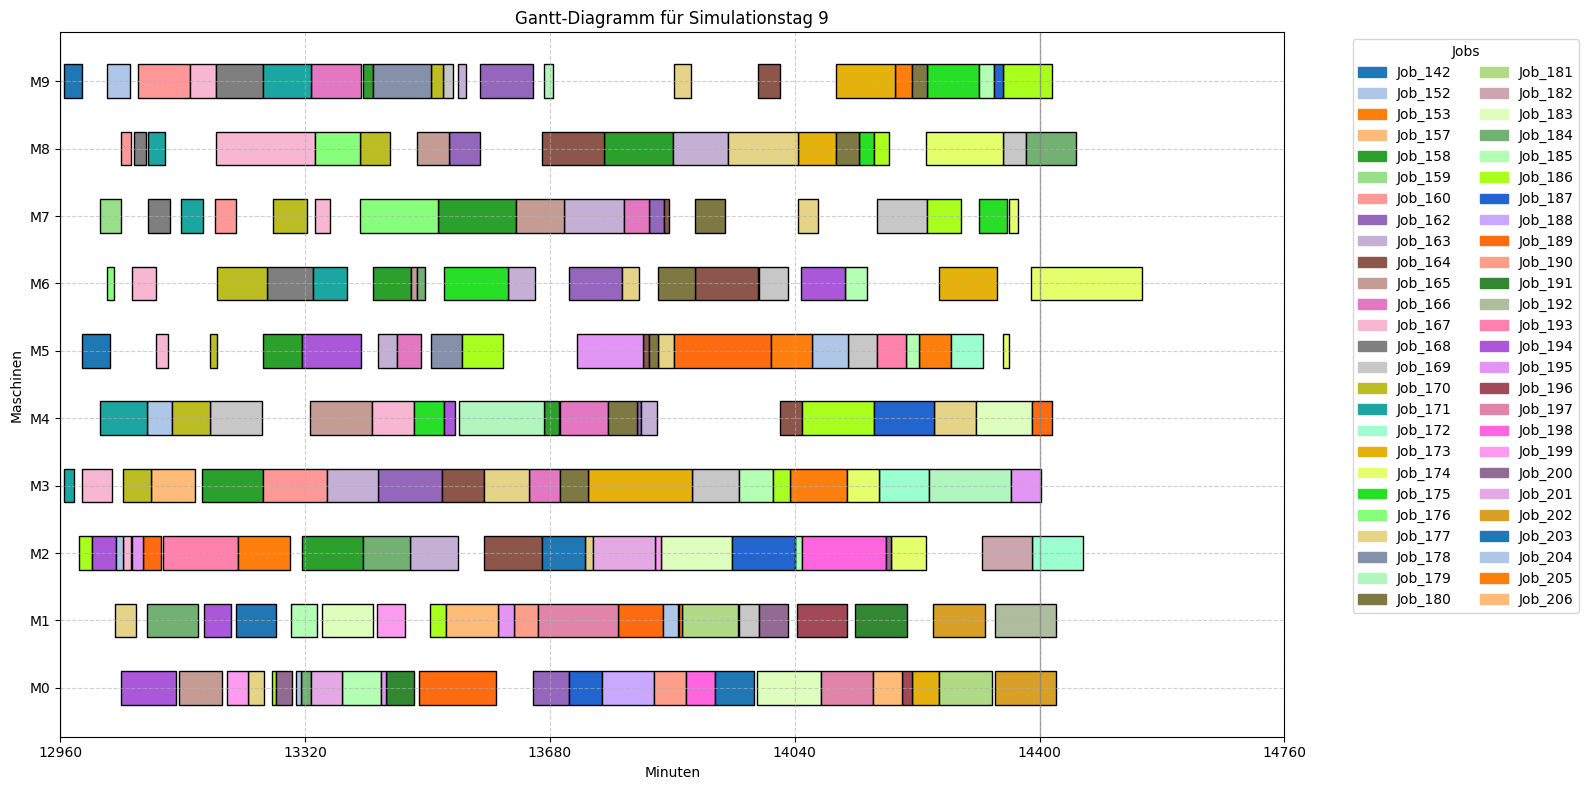

Number of undone operations: 24
_______________________________________________________________________________
Day 10: [14400, 15840)
	Current earliest Job_207:	Arrival: 12982	Deadline: 16117
	Undone earliest Job_165:	Arrival: 10535	Deadline: 14344
	Wating earliest Job_165:	Arrival: 10535	Deadline: 14344

Solver-Status         : FEASIBLE
Objective Value       : 150073.00
Best Objective Bound  : 106527.00
Laufzeit              : 1206.45 Sekunden


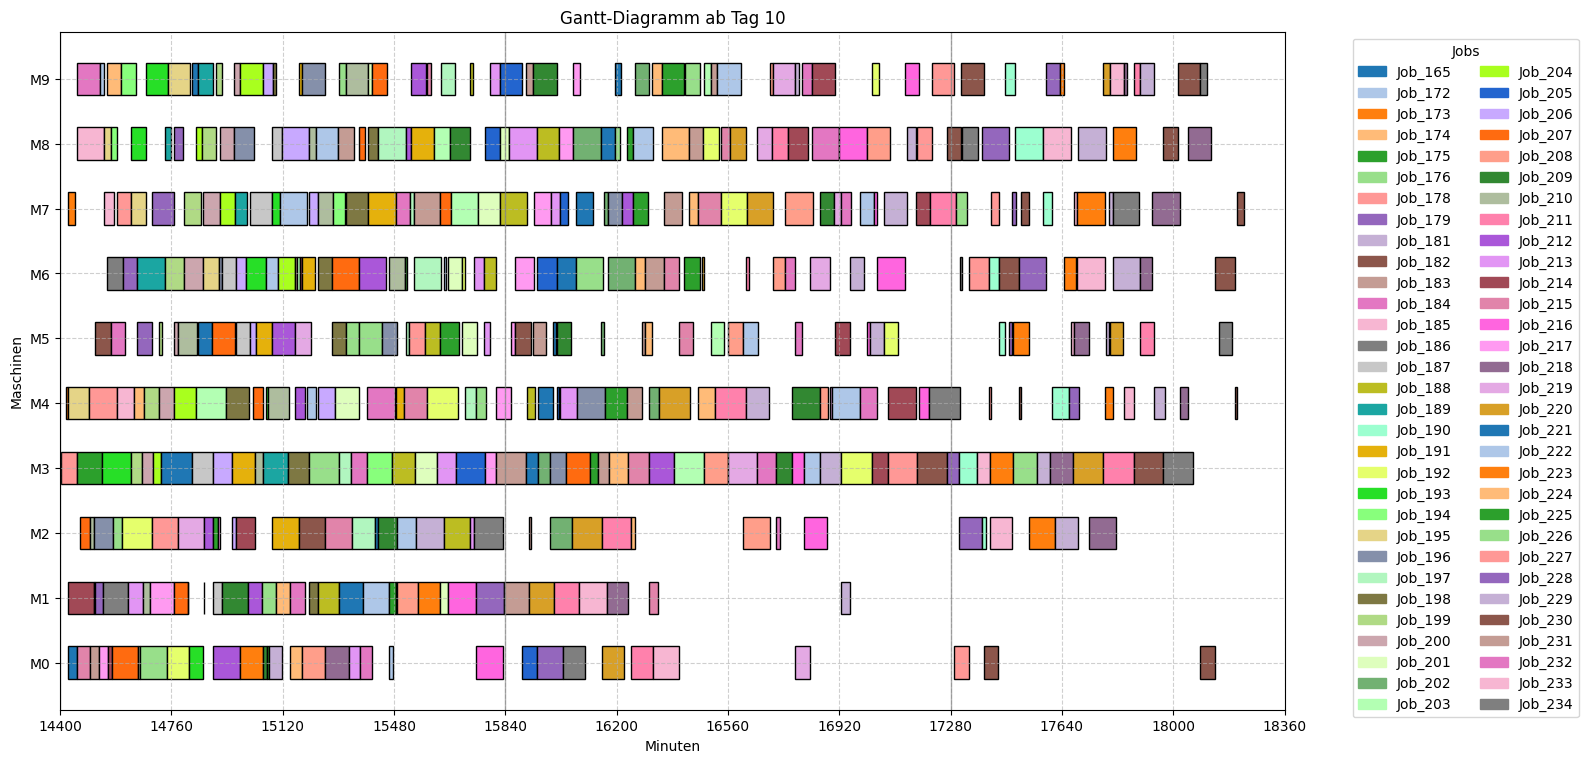

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0               4
0 - 60          4
60 - 120        2
120 - 180       6
180 - 240       6
>240           36
Name: count, dtype: int64
Number of waiting operations: 236
[240:03:00] Job_178 started on M3
[240:18:00] Job_173 started on M4
[240:24:00] Job_221 started on M0
[240:25:00] Job_214 started on M1
[240:27:40] Job_173 finished on M4 (after 09 minutes 40 seconds)
[240:27:40] Job_195 started on M4
[240:27:40] Job_173 started on M7
[240:54:00] Job_184 started on M9
[240:54:00] Job_185 started on M8
[240:57:31] Job_178 finished on M3 (after 54 minutes 32 seconds)
[240:57:31] Job_175 started on M3
[241:00:25] Job_173 finished on M7 (after 32 minutes 45 seconds)
[241:04:00] Job_207 starte

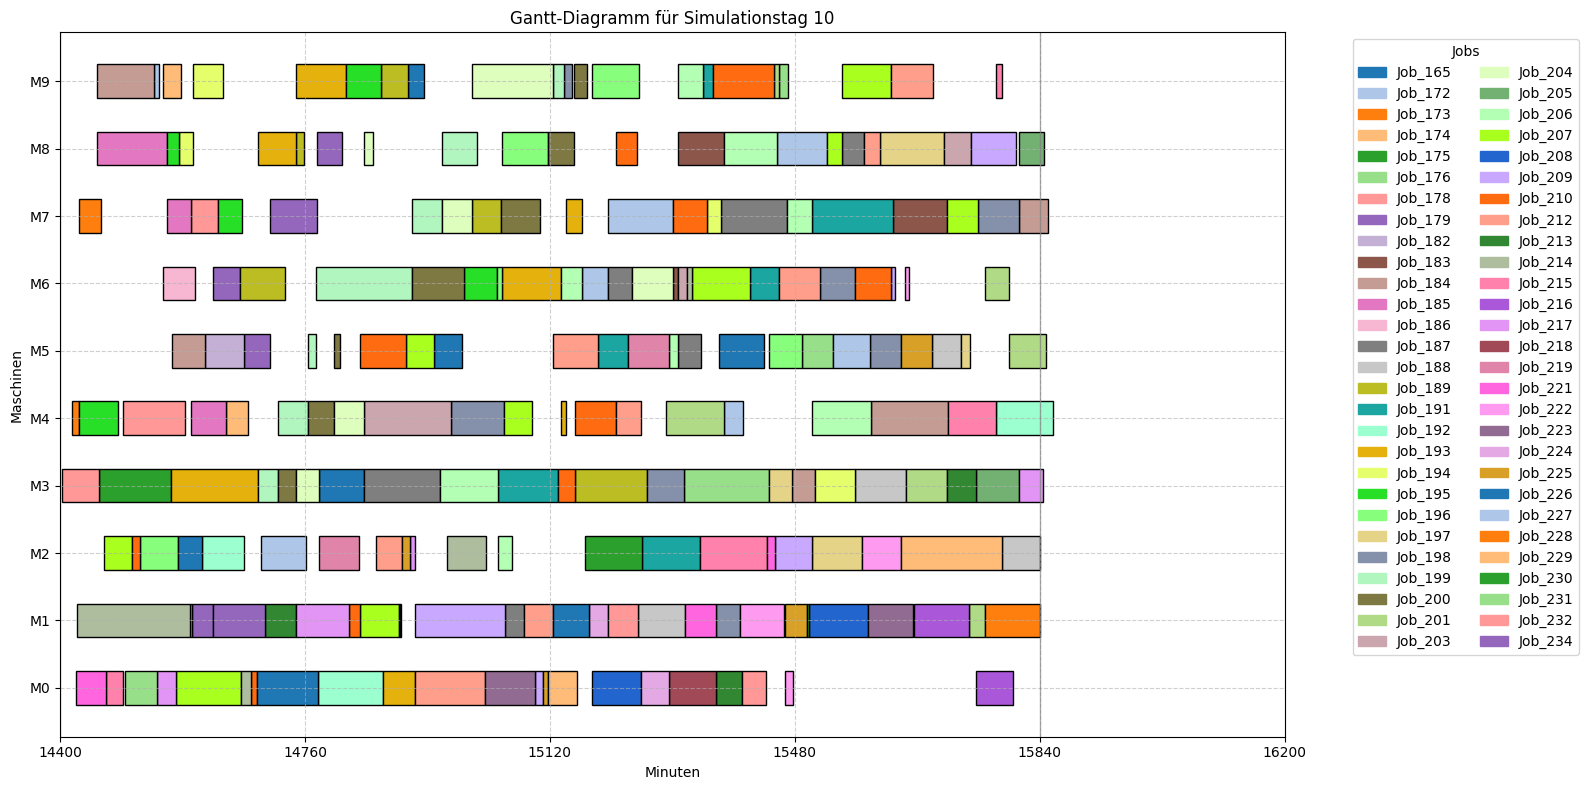

Number of undone operations: 24
_______________________________________________________________________________


In [14]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs_all, df_ops_all, ready_time = day_start)
    print_earliest_job(df_jobs_curr, "Current")

    # ---------- b) Unerledigte Operationen ----------------------------

    df_ops_undone = df_ops_all.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_undone = df_jobs_all[df_jobs_all["Job"].isin(df_ops_undone["Job"].unique())]
    print_earliest_job(df_jobs_undone, "Undone")
    
    # ---------- c) Wartende Operationen -------------------------------

    df_ops_waiting = df_ops_all.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_waiting = df_jobs_all[df_jobs_all["Job"].isin(df_plan_waiting["Job"].unique())]
    print_earliest_job(df_jobs_waiting, "Wating")

    # ---------- Zusammenführung ---------------------------------------

    df_ops_curr_combined = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
    df_jobs_curr_combined  = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
    df_jobs_curr_combined = df_jobs_curr_combined.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)

    # ------------------------ II. Rescheduling ---------------------------------
    #----------------------------------------------------------------------------

    # Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
    df_execution_important = df_execution[df_execution["End"] >= day_start]

    # Rescheduling
    df_plan = solver.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_ops_curr_combined, df_jobs_curr_combined , 
                                                                                    df_execution_important,
                                                                                    w_t = 5,
                                                                                    reschedule_start = day_start, msg=False, 
                                                                                    timeLimit=max_time, gapRel= 0.002)
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_plan.to_csv(data_path / file, index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.is_machine_conflict_free(df_plan)
    check.is_operation_sequence_correct(df_plan)
    check.is_job_timing_correct(df_plan)
    check.is_start_correct(df_plan)
    
    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    
    # ------------------------ III. Aufteilung des Schedules --------------------

    df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
    
    df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
    waiting_numb = len(df_plan_waiting)
    print(f"Number of waiting operations: {waiting_numb}")


    # ------------------------ IV. Simulation -----------------------------------

    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
    df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    undone_numb = len(df_plan_undone)
    print(f"Number of undone operations: {undone_numb}")
    print("_"*79)